In [309]:
%matplotlib inline
from __future__ import division, print_function
import matplotlib as mpl
mpl.style.use('classic')
import matplotlib.pyplot as plt
import numpy as np
import h5py
from scipy import signal, linalg
from ipywidgets import interact

In [674]:
import sklearn
from scipy import linalg, signal, optimize
import lockin
import phasekick2 as pk2
import phasekick as pk
import tqdm
import sigutils
import munch
%reload_ext timedomainfit
from timedomainfit import *
import timedomainfit as td
import pystan

def svdsqrtm(x, eps=1e-15):
    """Return the matrix square root of x calculating using the svd.
    
    Set singular values < eps to 0.
    This prevents numerical errors from making sqrtm(x) complex
    (small eigenvalues of x accidently negative)."""
    u, s, v = linalg.svd(x)
    s_pos = np.zeros_like(s)
    for i in xrange(s.size):
        if s[i] > eps:
            s_pos[i] = s[i]

    return np.dot(u, np.dot(np.diag(np.sqrt(s_pos)), v.T))


def unscented(x, P, scale=1.0, eps=1e-15):
    u""""For a vector x of length N with covariance matrix P,
    form 2N sigma points used for taking the unscented transform.

                                      __
    Defaults to taking points at x ± √NP."""
    x = x.ravel() # Force shape
    N = x.size
    Psqrt = scale * svdsqrtm(N * P, eps)
    x_sigma = []

    for i in xrange(N):
        x_sigma.append(x + Psqrt[:, i])

    for i in xrange(N):
        x_sigma.append(x - Psqrt[:, i])

    return x_sigma

def dc_plus_ac2(t_, tau, t0, dx, X0, Y0, tau_df):
    t = t_ - t0
    omega = 0.06185 * 2 * np.pi
    omega0 = 0.062 * 2 * np.pi
    omega_tau2 = (omega * tau)**2
    phi = pk.phase_step(t, tau_df, 1.0)
    x_light = (dx * (1 - omega_tau2 / (1 + omega_tau2) * np.exp(-t/tau)) - 
              dx / (1 + omega_tau2) * (np.cos(omega * t) + omega * tau * np.sin(omega*t))
              ) - np.where(t>2*tau, dx/530.0*t, 0)
    x_df = X0 * phi * np.cos(t*omega) + Y0 * phi * np.sin(t*omega)
    return np.where(t > 0, x_light + 1e-3*x_df, 0)


def dc_plus_ac3(t_, tau, t0, dx, tau_df, df):
    t = t_ - t0
    omega = 0.062 * 2 * np.pi
    omega_tau2 = (omega * tau)**2
    phi = pk.phase_step(t, tau_df, df) * 2*np.pi
    x_light = (dx * (1 - omega_tau2 / (1 + omega_tau2) * np.exp(-t/tau)) - 
              dx / (1 + omega_tau2) * (np.cos(omega * t) + omega * tau * np.sin(omega*t))
              )
    X0=-11.22
    Y0=-44.25
    x_df = X0 * phi * np.cos(t_*omega) + Y0 * phi * np.sin(t_*omega)
    return np.where(t > 0, x_light + 1e-3*x_df, 0)

def plot_stuff(tau, t0, x_dc, X0, Y0, tau_df):
    plt.plot(bi_all.t_us[m], bi_all.resid[m])
    plt.plot(bi_all.t_us[m], dc_plus_ac2(bi_all.t_us[m], tau, t0, x_dc, X0, Y0, tau_df))
    
def align_labels(axes_list,lim, axis='y'):
    for ax in axes_list:
        t = ax.yaxis.label.get_transform()
        x,y = ax.yaxis.label.get_position()
        ax.yaxis.set_label_coords(lim,y,t)


In [311]:
mpl.rc('font', size='9')

In [4]:
fh = h5py.File("../../data/tr-efm/151218-003450-100sun-784.h5", "r")
params =   {'fp': 4000,
             'fc': 15000,
             't_phase': -0.052,
             'ti': -54e-3,
             'tf': 6e-3,
             'Ndec': 1}
fir = lockin.lock2(66000, params['fp'], params['fc'], fs=1e6)

Response:
f   mag       dB
    0.000 1.000    0.000
 2000.000 0.982   -0.161
 4000.000 0.921   -0.715
15000.000 0.098  -20.164
30000.000 0.000 -101.125
33000.000 0.000 -110.366
66000.000 0.000 -141.187
500000.000 0.000 -196.320


In [5]:
bi = td.signal_average_gr_parab(fh['data'], -1.5e-3, 0, invert=False, align_voltage=True)

Response:
f   mag       dB
    0.000 1.000   -0.000
 3099.931 0.983   -0.152
 6199.861 0.927   -0.660
24799.444 0.096  -20.369
30999.305 0.011  -38.830
49598.888 0.000 -101.957
61998.610 0.000 -110.975
500000.000 0.000 -179.337


In [6]:
bidamped = fit_damped_sine_eliminate_harmonics(bi.t_ms, bi.x, p0=np.array([0, 0, 62.0, 0.0, 0.0]))

In [7]:
bi_all = td.signal_average_gr_parab(fh['data'], -1.5e-3, 1.4e-3, invert=False, align_voltage=True)

Response:
f   mag       dB
    0.000 1.000   -0.000
 3096.811 0.983   -0.152
 6193.623 0.927   -0.661
24774.492 0.096  -20.354
30968.115 0.011  -38.789
49548.983 0.000 -101.976
61936.229 0.000 -111.030
500000.000 0.000 -179.312


In [8]:
remove_harmonics(bi_all, bidamped)

In [346]:
m = pk.masklh(bi_all.t_ms, -10e-3, 30e-3)

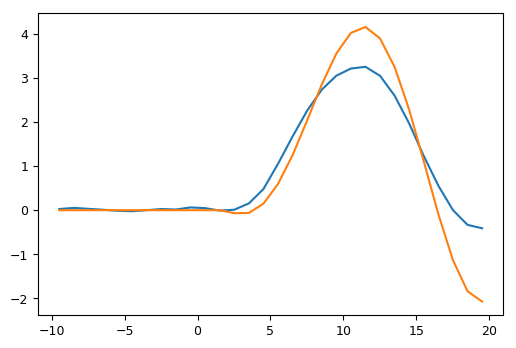

In [140]:
plt.plot(bi_all.t_us[m], bi_all.resid[m])
plt.plot(bi_all.t_us[m], dc_plus_ac3(bi_all.t_us[m], 1.0, 1.7, 1.55, 0.1, 0.07*6.28))

In [142]:
# popt, pcov = optimize.curve_fit(dc_plus_ac2, bi_all.t_us[m], bi_all.resid[m], sigma=bi_all.x_err[m],
#                                 p0=np.array([0.05, 2.4, 1.55, -16, -36, 0.07]),
#                                method='dogbox')

/Users/ryandwyer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in add
/Users/ryandwyer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: overflow encountered in exp


In [144]:
# fit = dc_plus_ac2(bi_all.t_us[m], *popt)

/Users/ryandwyer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: overflow encountered in exp


In [675]:
def dc_plus_ac2_exp(t_, tau_log, t0, dx, X0, Y0):
    t = t_ - t0
    omega = 0.06185 * 2 * np.pi
    omega0 = 0.062 * 2 * np.pi
    tau = np.exp(tau_log)
    omega_tau2 = (omega * tau)**2
    phi = pk.phase_step(t, 1e-4, 1.0)
    x_light = (dx * (1 - omega_tau2 / (1 + omega_tau2) * np.exp(-t/tau)) - 
              dx / (1 + omega_tau2) * (np.cos(omega * t) + omega * tau * np.sin(omega*t))
              ) - np.where(t>2*tau, dx/530.0*t, 0)
    x_df = X0 * phi * np.cos(t*omega) + Y0 * phi * np.sin(t*omega)
    return np.where(t > 0, x_light + 1e-3*x_df, 0)

In [676]:
# pcov.diagonal()**0.5

In [677]:
popt, pcov = optimize.curve_fit(dc_plus_ac2_exp, bi_all.t_us[m], bi_all.resid[m],
                                p0=np.array([-1,   1.85957573e+00,   1.59650452e+00,
        -6.01417104e+00,  -3.67138821e+01])
                               )

/Users/ryandwyer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in add


In [678]:
pts = unscented(popt, pcov, scale=0.00035, eps=100)

In [679]:
# popt, pcov = optimize.curve_fit(dc_plus_ac2, bi_all.t_us[m], bi_all.resid[m],
#                                 p0=np.array([  3.68420573e-01,   1.85957573e+00,   1.59650452e+00,
#         -6.01417104e+00,  -3.6b7138821e+01,   2.68239469e-06])
#                                )

/Users/ryandwyer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: overflow encountered in exp
/Users/ryandwyer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in add
/Users/ryandwyer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in add


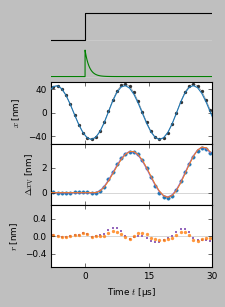

In [1110]:
mpl.rc('font', size=8)
mpl.rc('axes', edgecolor='0')
fig = plt.figure(figsize=(2.6, 4.05))
gs = mpl.gridspec.GridSpec(21, 1)
axes = []
iend = [3, 6, 11, 16]
axes.append(fig.add_subplot(gs[:iend[0]]))
for i,i_next in zip(iend[:-1], iend[1:]):
    axes.append(fig.add_subplot(gs[i:i_next], sharex=axes[0]))

axes.append(fig.add_subplot(gs[iend[-1]:]))
fig.subplots_adjust(wspace=0.0, hspace=0)

tpts = np.array([-50, 0, 0, 150])
Vpts = np.array([0, 0, 1, 1])

axes[0].plot(tpts, Vpts, 'k')
axes[0].set_ylim(-0.2, 1.2)
axes[0].set_yticks([0, 1])
axes[0].set_yticklabels(['$0$', ''])
axes[0].set_xticklabels([''])

axes[0].set_xlim(-8, 30)

axes[0].set_ylabel("$V_\\mathrm{t}$")

pts_color = u'#1f77b4'
light_color = u'#ff7f0e'
dark_color = u'#9467bd'

t_exp_pos = np.r_[np.linspace(0,15, 101), 200]
t_exp = np.r_[[-50, 0], t_exp_pos]
x_exp = np.r_[0, 0, np.exp(-t_exp_pos/1.0)]

axes[1].plot(t_exp, x_exp, 'g')
axes[1].set_ylim(-0.2, 1.2)
axes[1].set_ylabel("$G$")

for ax in [axes[i] for i in [0, 1, 3, 4]]:
    ax.axhline(color='0.8', linewidth=0.7, zorder=0)

# axes[2].plot()
# axes[2].set_ylabel("$H$")

ax_x = axes[2]

ax_x.plot(bi_all.t_us, bi_all.x, linewidth=0.5, color='0.5')
ax_x.plot(bi_all.t_us, bi_all.x, '.', color='0.2', markeredgewidth=0)
ax_x.plot(bi_all.t_us, bi_all.x - bi_all.resid, '-', color=pts_color, linewidth=1, alpha=1, zorder=4)
ax_x.set_ylim(-52, 52)
ax_x.set_yticks([-40, 0, 40])
# ax_x.set_yticklabels([u'−40', '', '40'])
ax_x.set_ylabel('$x$ [nm]')


ax_r = axes[3]

# ax_r.plot(bi_all.t_us, bi_all.resid, '-', color='0.6',linewidth=0.7)
ax_r.plot(bi_all.t_us, bi_all.resid, '.', color=pts_color, zorder=1)

# popt = np.array([0.8, 1.9, 1.55, -28,  -5, 1e-5])

# ax_r.plot(bi_all.t_us[m], dc_plus_ac2_exp(bi_all.t_us[m], *popt))
ax_r.plot(bi_all.t_us[m], dc_plus_ac2_exp(bi_all.t_us[m], *pts[5]), color=dark_color, linewidth=1.25, alpha=1, zorder=2)
ax_r.plot(bi_all.t_us[m], dc_plus_ac2_exp(bi_all.t_us[m], *pts[0]), color=light_color, alpha=1, linewidth=0.75, zorder=3)
ax_r.set_ylim(-1, 3.9)
ax_r.set_yticks([0, 2])
# ax_r.set_yticklabels([u'−3', '', '3'])
ax_r.set_ylabel('$\\Delta x_\\mathrm{V}$ [nm]')

markeredgewidth=0
# axes[-1].plot(bi_all.t_us[m],
#               1*(bi_all.resid[m] - dc_plus_ac2_exp(bi_all.t_us[m], *popt)),
#               '.', markeredgewidth=markeredgewidth)
axes[-1].plot(bi_all.t_us[m],
              1*(bi_all.resid[m] - dc_plus_ac2_exp(bi_all.t_us[m], *pts[0])),
              's', markersize=2.5, markeredgewidth=markeredgewidth, color=dark_color, alpha=1)
axes[-1].plot(bi_all.t_us[m],
              1*(bi_all.resid[m] - dc_plus_ac2_exp(bi_all.t_us[m], *pts[5])),
              '.',  markeredgewidth=markeredgewidth, color=light_color, alpha=0.8)
axes[-1].set_xlim(*axes[0].get_xlim())
axes[-1].set_ylim(-0.7, 0.7)
axes[-1].set_xlabel(u"Time $t$ [µs]")
axes[-1].set_ylabel('$r$ [nm]')
axes[-1].set_yticks([-0.4, 0, 0.4])

for ax in axes[:2]:
    ax.set_frame_on(False)
    ax.set_axis_off()

for ax in axes[-2:]:
    ax.set_xticks([0, 15, 30])

In [1111]:
align_labels(axes, 19)

In [1112]:
np.exp(popt[0])

0.059409682232404407

In [1113]:
np.exp(pts[0][0])

0.34769574779581874

In [1114]:
np.exp(pts[5][0])

0.010151146125111489

In [1115]:
fig.savefig('ex3.pdf', bbox_inches='tight', pad_inches=0.25, transparent=True)

In [1116]:
!open ex3.pdf

In [1103]:
!cp ex2.pdf /Users/ryandwyer/Dropbox/_JAM_MS__Dwyer201511__Phasekick__figs/raw-figures/tr-EFM-raw-time-domain.pdf

In [967]:
def fit_both_parts(t_, f1, f2, X0, Y0, tau, dx, Q):
    t0 = 2.4
    t = t_ - t0
    phi = fit_both_parts_phi(t_, f1, f2, X0, Y0, tau, dx)
    
    omega = f2 * 2e-6 * np.pi
    omega_tau2 = (omega * tau)**2
    x_light = (dx * (1 - omega_tau2 / (1 + omega_tau2) * np.exp(-t/tau)) - 
              dx / (1 + omega_tau2) * (np.cos(omega * t) + omega * tau * np.sin(omega*t))
              )
    return X0*np.cos(phi) + Y0*np.sin(phi) + np.where(t>0, x_light, 0)

def fit_both_parts_phi(t_, f1, f2, X0, Y0, tau, dx, Q):
    t0 = 2.4
    t = t_ - t0
    return np.where(t > 0,
                  2e-6*np.pi*f2*t,
                  2e-6*np.pi*f1*t
                  )

In [263]:
m = pk.masklh(bi_all.t_us, -100, 100)

In [264]:
popt, pcov = optimize.curve_fit(fit_both_parts, bi_all.t_us[m], bi_all.x[m],
                               p0=[6.20054572e+04, 6.18514996e+04,  -25*1.46, 16*1.46, 0.1, 1.55])
fit = fit_both_parts(bi_all.t_us[m], *popt)


resid =  bi_all.x[m] - fit
A = harNphi(fit_both_parts_phi(bi_all.t_us[m], *popt), 5)
fitout = linalg.lstsq(A, resid)
resid_no_harmon = resid - np.dot(A, fitout[0])

/Users/ryandwyer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: overflow encountered in exp


In [268]:

fit2 = fit_both_parts(bi_all.t_us[m], *popt)


resid2 =  bi_all.x[m] - fit2
A = harNphi(fit_both_parts_phi(bi_all.t_us[m], *popt), 5)
fitout = linalg.lstsq(A, resid)
resid_no_harmon = resid - np.dot(A, fitout[0])

array([  6.20166677e+04,   6.18566881e+04,  -4.21094012e+01,
         1.79856630e+01,   2.50380858e-05,   1.35123608e+00])

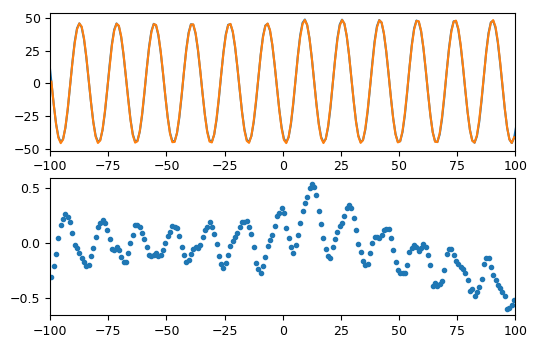

In [272]:
fig, (ax1, ax2) = plt.subplots(nrows=2)
ax1.plot(bi_all.t_us, bi_all.x)

# popt = np.array([ 2.40173225e+00,   6.20054586e+04,   6.18514977e+04,
#          -25*1.46, 16*1.46,   2.00000000e-01,
#          1.55000000e+00])

# fit = fit_both_parts(bi_all.t_us[m], *popt)


# resid =  bi_all.x[m] - fit
# A = harNphi(fit_both_parts_phi(bi_all.t_us[m], *popt), 5)

ax1.plot(bi_all.t_us[m], fit)
ax1.set_xlim(-100, 100)
ax2.set_xlim(-100, 100)
# td.harNphi(fit_both_parts_phi())
# ax2.plot(bi_all.t_us[m], resid)
ax2.plot(bi_all.t_us[m], resid_no_harmon, '.')


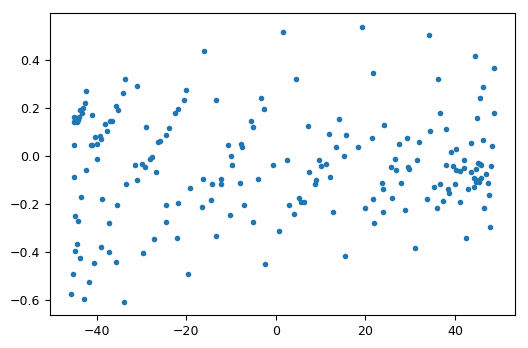

In [271]:
plt.plot(bi_all.x[m], resid_no_harmon, '.')

In [177]:
fig.savefig('ex2.pdf', bbox_inches='tight', transparent=True)

In [178]:
!open ex2.pdf